# Flag QC-failed imaging wells

__Many imaging wells may have poor qualities due to different reasons, such as insufficient cells, microscopic lighting issues, etc. This notebook aims to analyze the qualities of all the imaged wells and flag the ones with poor qualities to exclude them in the downstream analyses.__

In [1]:
import os
import pickle
import warnings
import numpy as np
import polars as pl
import pandas as pd
from tqdm import tqdm
from scipy import stats
import seaborn as sns
import statsmodels.formula.api as smf
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import sys
from skimage.filters import threshold_triangle
sys.path.append("../..")
from img_utils import *

letter_dict_rev = {v: k for k, v in letter_dict.items()}
channel_dict_rev = {v: k for k, v in channel_dict.items()}

# letter_dict_rev
channel_list = list(channel_dict_rev.values())[:-3]
channel_list

%matplotlib inline

## 1. Processing QC results

__Label the QC-flag per each channel of a imaging well in every plate, based on the signal-to-noise ratio (99th-percentile pixel intensity / 25th-percentile pixel intensity) across the plate.__

### 1.1 Get the signal-to-noise ratio per each channel in each imaging well

In [2]:
def get_plate_well_s2n(batch, img_qc_dir):
    plate_sum = pl.read_parquet(f"{img_qc_dir}/{batch}/plate_sum_stats.parquet")
    plate_well_sum = pl.read_parquet(f"{img_qc_dir}/{batch}/plate_well_sum_stats.parquet").with_columns(
        pl.lit(batch).alias("Metadata_Batch")
    )
    
    plate_well_sum = plate_well_sum.filter(
        ~(pl.col("channel").str.contains("Brightfield"))
    ).join(
        plate_sum.rename({"perc_50": "median_plate"}), on=["plate","channel"], how="left", suffix="_plate"
    ).sort(by=["plate", "well"])

    plates = sorted(plate_well_sum["plate"].unique())
    plate_well_sum_with_metrics = pl.DataFrame()

    for plate in plates: #plate_well_sum.group_by("plate"):
        for channel in channel_list:
            # print(plate, channel)
            ## Calculate the s2n ratio per each well
            ## Using the background (plate_median) per that plate
            plate_channel_plate = plate_well_sum.filter(
                (pl.col("plate")==plate)&(pl.col("channel")==channel)
            ).with_columns(
                ## calculate the s2n ratio against the plate median
                (pl.col("perc_99") / pl.col("median_plate")).alias("s2n_ratio_raw")
            ).filter(
                (~(pl.col("s2n_ratio_raw").is_infinite()))&(~(pl.col("s2n_ratio_raw").is_nan()))
            ).sort(by="s2n_ratio_raw")
            # --- DYNAMIC OFFSET CALCULATION (Half-Minimum Rule) ---
            # Extract values > 0 to find the minimum resolution limit
            positive_values = plate_channel_plate.filter(pl.col("s2n_ratio_raw") > 0)
            # Get the minimum positive value and divide by 2
            min_val = positive_values["s2n_ratio_raw"].min()
            offset = min_val / 2.0
            plate_channel_plate = plate_channel_plate.with_columns(
                np.log10(pl.col("s2n_ratio_raw")+offset).alias("s2n_ratio")
            )
            plate_well_sum_with_metrics = pl.concat([plate_well_sum_with_metrics, plate_channel_plate])
        
    return plate_well_sum_with_metrics

### 1.2 Gather the s2n ratio across all imaging wells

Label all the imaging wells with s2n ratio below the selected threshold as is_bg, which would be discarded in the downstream analyses.

{'DAPI': 0.3288421001897428, 'GFP': 0.2910260388538437, 'AGP': 0.3909742468941979, 'Mito': 0.6248080883775313}


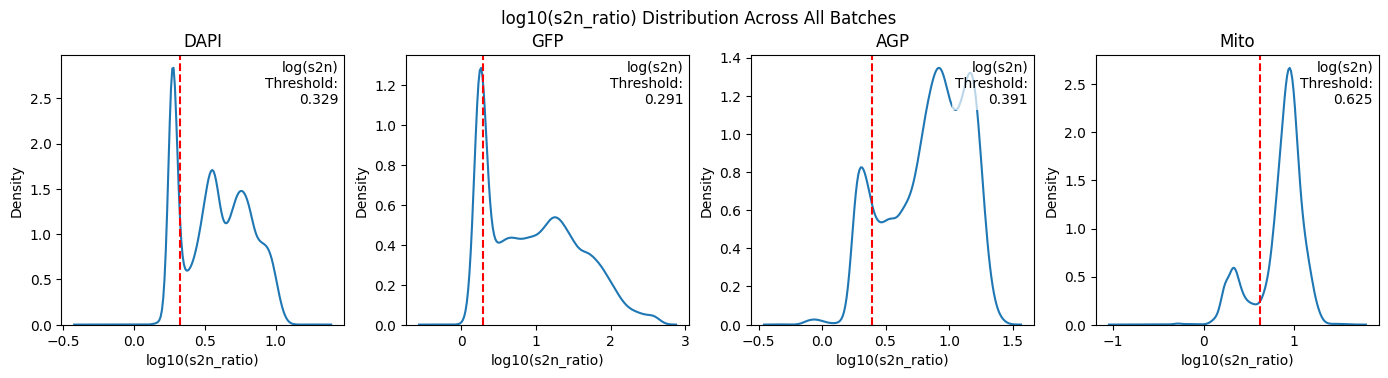

In [3]:
def get_left_tail_threshold(data) -> float:
    """
    Calculates the noise threshold for a Polars Series using the 
    Triangle method (assuming noise is on the left tail).
    """
    # 1. Convert Polars Series to NumPy array (usually zero-copy)
    # data = series.to_numpy()
    # # Handle edge case: drop NaNs if necessary
    # # Incorporated in the preprocessing
    # data = data[np.isfinite(data)]
    # if len(data) == 0:
    #     return 0.0
    # 2. Invert the distribution
    # Triangle method finds the "toe" on the right; we invert 
    # so our left-tail noise becomes that right-side toe.
    max_val = np.max(data)
    inverted_data = max_val - data
    
    # 3. Calculate threshold on inverted data
    thresh_inverted = threshold_triangle(inverted_data)
    
    # 4. Flip threshold back to original scale
    return max_val - thresh_inverted


channel_thresholds = {}
all_img_well_across_batches, all_img_well_across_batches_qc_info = pl.DataFrame(), pl.DataFrame()

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch in bio_rep_batches:
        # output_dir = f"{IMGS_QC_METRICS_DIR}/{bio_rep}"
        # if not os.path.exists(output_dir):
        #     os.makedirs(output_dir)
        plate_well_sum_with_metrics = get_plate_well_s2n(batch, IMGS_QC_BG_SUM_DIR)
        plate_well_sum_with_metrics = plate_well_sum_with_metrics.with_columns(
            pl.lit(bio_rep).alias("Metadata_Bio_Rep")
        )
        all_img_well_across_batches = pl.concat([all_img_well_across_batches, plate_well_sum_with_metrics])
        # for channel in channel_list:
        #     channel_vals[channel] += plate_well_sum_with_metrics.filter(pl.col("channel")==channel)["s2n_ratio"].to_numpy().tolist()

fig, axes = plt.subplots(1,4,figsize=(17,3.5))
for idx, channel in enumerate(channel_list):
    all_img_well_per_channel = all_img_well_across_batches.filter(pl.col("channel")==channel)
    channel_s2n_vals = all_img_well_per_channel["s2n_ratio"].to_numpy()
    threshold = get_left_tail_threshold(channel_s2n_vals)
    channel_thresholds[channel] = threshold
    channel_s2n_vals_qc = all_img_well_per_channel.with_columns(
        (pl.col("s2n_ratio") <= threshold).alias("is_bg")
    )
    all_img_well_across_batches_qc_info = pl.concat([
        all_img_well_across_batches_qc_info,
        channel_s2n_vals_qc
    ])
    ## plot the distrbutions
    sns.kdeplot(
        channel_s2n_vals, 
        # bins=100, 
        # kde=True,
        ax=axes[idx],
        # hist=False,             # This parameter must be here
        # stat="density"
    )
    axes[idx].axvline(threshold, color='red', linestyle='--', label='Threshold')
    axes[idx].set_title(f"{channel}")
    axes[idx].set_xlabel("log10(s2n_ratio)")
    axes[idx].set_ylabel("Density")
    axes[idx].text(
        x=0.98,                         # 5% from the left edge of the plot
        y=0.98,                         # 5% from the top edge of the plot
        s=f"log(s2n)\nThreshold:\n{threshold:.3f}", # The text content
        transform=axes[idx].transAxes,  # CRITICAL: This makes x,y 0-1 (axis-relative)
        ha='right',                      # Horizontal Alignment: Align text to the left of the x-coordinate
        va='top',                       # Vertical Alignment: Align text to the top of the y-coordinate
        fontsize=10,                    # Optional: Set the font size
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2) # Optional: Adds a white box behind the text
    )
plt.suptitle("log10(s2n_ratio) Distribution Across All Batches", y=1.01)
plt.subplots_adjust(wspace=.22)
# plt.savefig(f"{IMGS_QC_METRICS_DIR}/all_batches_log10_s2n_ratio_distribution_with_thresholds.png", dpi=150, bbox_inches='tight')
print(channel_thresholds)

# all_img_well_across_batches_qc_info.write_parquet("../inputs/1.plate_well_qc_metrics/all_img_wells_qc.parquet", compression="zstd")

In [4]:
## Loading data
all_img_well_across_batches_qc_info = pl.read_parquet("../inputs/1.plate_well_qc_metrics/all_img_wells_qc.parquet")

In [5]:
all_img_well_across_batches_qc_info.group_by(["channel", "is_bg"]).agg(
    pl.len()
).sort(
    by=["channel", "is_bg"]
).join(
    all_img_well_across_batches_qc_info.group_by(["channel"]).agg(
        pl.len()
    ),
    on="channel"
).with_columns(
    (pl.col("len") / pl.col("len_right") * 100).alias("perc")
)

shape: (8, 5)
┌─────────┬───────┬───────┬───────────┬───────────┐
│ channel ┆ is_bg ┆ len   ┆ len_right ┆ perc      │
│ ---     ┆ ---   ┆ ---   ┆ ---       ┆ ---       │
│ str     ┆ bool  ┆ u32   ┆ u32       ┆ f64       │
╞═════════╪═══════╪═══════╪═══════════╪═══════════╡
│ AGP     ┆ false ┆ 25220 ┆ 29184     ┆ 86.417215 │
│ AGP     ┆ true  ┆ 3964  ┆ 29184     ┆ 13.582785 │
│ DAPI    ┆ false ┆ 22373 ┆ 29184     ┆ 76.66187  │
│ DAPI    ┆ true  ┆ 6811  ┆ 29184     ┆ 23.33813  │
│ GFP     ┆ false ┆ 22285 ┆ 29184     ┆ 76.360334 │
│ GFP     ┆ true  ┆ 6899  ┆ 29184     ┆ 23.639666 │
│ Mito    ┆ false ┆ 24095 ┆ 29184     ┆ 82.562363 │
│ Mito    ┆ true  ┆ 5089  ┆ 29184     ┆ 17.437637 │
└─────────┴───────┴───────┴───────────┴───────────┘

## 2. Label poor-quality imaging wells with allele meta data

In [ ]:
# allele_meta_dict = {}
# for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
#     for batch_id in bio_rep_batches:
#         allele_meta_df = pl.DataFrame()
#         platemaps = [file for file in os.listdir(PLATEMAP_DIR.format(batch_id=batch_id)) if file.endswith(".txt")]
#         for platemap in platemaps:
#             platemap_df = pl.read_csv(os.path.join(PLATEMAP_DIR.format(batch_id=batch_id), platemap), separator="\t", infer_schema_length=100000)
#             allele_meta_df = pl.concat([allele_meta_df, 
#                                         platemap_df.filter((pl.col("node_type").is_not_null()))], # (~pl.col("node_type").is_in(["TC","NC","PC"]))&
#                                         how="diagonal_relaxed").sort("plate_map_name")
#             allele_meta_df = allele_meta_df.with_columns(pl.col("plate_map_name").alias("plate_map")) ## str.split('_').list.get(0).
#             # display(allele_meta_df.head())
#         allele_meta_dict[batch_id] = allele_meta_df

allele_meta_df = pl.DataFrame()
for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        allele_meta_df_batch = pl.DataFrame()
        platemaps = [file for file in os.listdir(PLATEMAP_DIR.format(batch_id=batch_id)) if file.endswith(".txt")]
        for platemap in platemaps:
            platemap_df = pl.read_csv(os.path.join(PLATEMAP_DIR.format(batch_id=batch_id), platemap), separator="\t", infer_schema_length=100000)
            allele_meta_df_batch = pl.concat([allele_meta_df_batch, 
                                        platemap_df.filter((pl.col("node_type").is_not_null()))], # (~pl.col("node_type").is_in(["TC","NC","PC"]))&
                                        how="diagonal_relaxed").sort("plate_map_name")
            allele_meta_df_batch = allele_meta_df_batch.with_columns(pl.col("plate_map_name").alias("plate_map")) ## str.split('_').list.get(0).
        allele_meta_df_batch = allele_meta_df_batch.with_columns(
            pl.lit(batch_id).alias("Metadata_Batch"),
            pl.lit(bio_rep).alias("Metadata_Bio_Rep")
        )
        allele_meta_df = pl.concat([
            allele_meta_df,
            allele_meta_df_batch
        ], how="diagonal_relaxed")#.sort("plate_map_name") ## (~pl.col("node_type").is_in(["TC","NC","PC"]))&
        
# allele_meta_df.write_parquet(IMG_METADATA_PARQUET_FILE, compression="zstd")

In [7]:
for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    img_well_qc_sum = pl.DataFrame()
    # well_agg_allele_qc_sum = pl.DataFrame()
    output_dir = f"{IMGS_QC_METRICS_DIR}/{bio_rep}"
    for batch_id in bio_rep_batches:
        ## load image qc
        # plate_img_qc = pl.read_parquet(f"{output_dir}/{batch_id}/plate_well_sum_with_qc_metrics.parquet")
        plate_img_qc = all_img_well_across_batches_qc_info.filter(pl.col("Metadata_Batch")==batch_id)
        if bio_rep == "2024_12_Batch_11-12":
            ## remove the widefield platemaps
            plate_img_qc = plate_img_qc.filter(~pl.col("plate").str.contains("widefield"))
            plate_img_qc = plate_img_qc.with_columns(
                pl.concat_str([pl.col("plate").str.extract(r"(B[^T]*)",1), pl.lit("_P1")]).alias("plate_id") ##.str.split('_').list.get(-2)
            ).with_columns(
                pl.concat_str([pl.col("plate_id"), pl.col("well")], separator="-").alias("plate_well")
            )
            ## load allele metadata
            allele_meta_df_batch = allele_meta_df.filter(
                pl.col("Metadata_Batch")==batch_id
            ).with_columns(
                pl.concat_str([pl.col("plate_map"), pl.col("well_position")], separator="-").alias("plate_well")
            )
        elif bio_rep == "2025_01_Batch_13-14":
            ## map the plate_well together
            plate_img_qc = plate_img_qc.with_columns(
                pl.col("plate").str.split('_').list.get(-2).alias("plate_id"),
            ).with_columns(
                pl.concat_str([pl.col("plate_id"),pl.col("well")], separator="-").alias("plate_well")
            )
            # print(plate_img_qc)
            allele_meta_df_batch = allele_meta_df.filter(
                pl.col("Metadata_Batch")==batch_id
            ).with_columns(
                pl.col("plate_map").str.split('_').list.get(0).alias("plate")
            ).with_columns(
                pl.concat_str([pl.col("plate"), pl.col("well_position")], separator="-").alias("plate_well")
            )
        elif bio_rep == "2025_03_Batch_15-16":
            ## map the plate_well together
            plate_img_qc = plate_img_qc.with_columns(
                pl.concat_str([
                    pl.lit("B"),
                    pl.col("plate").str.split('_B').list.get(-1).str.split('T').list.get(0).str.replace('_', '')
                ]).alias("plate_id"),
            ).with_columns(
                pl.concat_str([pl.col("plate_id"),pl.col("well")], separator="-").alias("plate_well")
            )
            # print(plate_img_qc)
            allele_meta_df_batch = allele_meta_df.filter(
                pl.col("Metadata_Batch")==batch_id
            ).with_columns(
                pl.col("plate_map").str.split('_').list.get(0).alias("plate")
            ).with_columns(
                pl.concat_str([pl.col("plate"), pl.col("well_position")], separator="-").alias("plate_well")
            )
        else:
            ## map the plate_well together
            plate_img_qc = plate_img_qc.with_columns(
                pl.col("plate").str.extract(r"(B[^T]*)",1).alias("plate_id") ##.str.split('_').list.get(-2)
            ).with_columns(
                pl.concat_str([pl.col("plate_id"),pl.col("well")], separator="-").alias("plate_well")
            )
            ## load allele metadata
            allele_meta_df_batch = allele_meta_df.filter(
                pl.col("Metadata_Batch")==batch_id
            ).with_columns(
                pl.concat_str([pl.col("plate_map"), pl.col("well_position")], separator="-").alias("plate_well")
            )
            
        
        if "plate" in allele_meta_df_batch.columns:
            allele_meta_df_batch = allele_meta_df_batch.drop("plate", "plate_map")
        else:
            allele_meta_df_batch = allele_meta_df_batch.drop("plate_map")
        
        plate_img_qc = plate_img_qc.join(
            allele_meta_df_batch, 
            on="plate_well", how="left"
        ).filter(
            (pl.col("gene_allele").is_not_null())
        )
        print(f"Batch {batch_id}: Total wells with allele info: {plate_img_qc.select(pl.col('plate_well')).n_unique()}")
        img_well_qc_sum = pl.concat([img_well_qc_sum, plate_img_qc], how="diagonal_relaxed")
        
        # for channel in channel_list:
        #     plate_img_qc_ch = plate_img_qc.filter(pl.col("channel")==channel)
        #     plate_maps = sorted(plate_img_qc_ch["plate_map_name"].unique())
        #     # print(plate_maps)
        #     # for plate_map in plate_maps:
        #     #     plate_img_qc_ch_pm = plate_img_qc_ch.filter(pl.col("plate_map_name")==plate_map)
        #     #     plates = sorted(plate_img_qc_ch_pm["plate"].unique().to_list())
        #     #     # print(plates)
        #     #     plot_platemap(
        #     #         plate_img_qc_ch_pm.filter(pl.col("plate")==plates[0]),
        #     #         plates[0]+f"_{channel}",
        #     #         well_pos_col="well",
        #     #         # this is the column to color by (categorical or continuous)
        #     #         value_col="node_type",
        #     #         # these columns will be concatenated into the annotation text
        #     #         label_cols=("gene_allele",),
        #     #         value_type="categorical",   # or "continuous"
        #     #         continuous_cmap="vlag",  # matplotlib colormap for continuous mode
        #     #         # categorical_colors={True: "tomato", False: "skyblue"},     # dict for categorical → color
        #     #         grid_square=None
        #     #     )
        #     #     break
        #     #     fig, axes = plt.subplots(2,2,figsize=(44,23)) ## sharey=True,sharex=True
        #     #     for plate in plates:
        #     #         plate_info = plate_img_qc_ch_pm.filter(pl.col("plate")==plate)
        #     #         # display(plate_info.filter(pl.col("is_bg")))
        #     #         # print(plates.index(plate))
        #     #         plot_platemap(
        #     #             plate_info,
        #     #             plate+f"_{channel}",
        #     #             well_pos_col="well",
        #     #             # this is the column to color by (categorical or continuous)
        #     #             value_col="is_bg",
        #     #             # these columns will be concatenated into the annotation text
        #     #             label_cols=("gene_allele",),
        #     #             ax=axes[plates.index(plate)//2, plates.index(plate)%2],
        #     #             value_type="categorical",   # or "continuous"
        #     #             continuous_cmap="vlag",  # matplotlib colormap for continuous mode
        #     #             categorical_colors={True: "tomato", False: "skyblue"},     # dict for categorical → color
        #     #             grid_square=None
        #     #         )
        #     #     fig.subplots_adjust(wspace=-.61, hspace=.05)
        #     #     plt.tight_layout()
        #     #     break
        #     well_img_qc_ch_sum_batch = plate_img_qc_ch.group_by(["gene_allele","well"]).agg(
        #         pl.col("is_bg").sum().alias("is_bg_sum"),
        #     ).with_columns(
        #         pl.lit(batch_id).alias("Batch"),
        #         pl.when(pl.col("is_bg_sum")>=3)
        #         .then(pl.lit("FAIL"))
        #         .otherwise(pl.lit("PASS"))
        #         .alias("QC_Flag")
        #     )
        #     well_agg_allele_qc_sum = pl.concat([well_agg_allele_qc_sum, well_img_qc_ch_sum_batch])

    # print("Writed outputs at:", f"{output_dir}/allele-level_img_qc_sum.csv")
    # well_agg_allele_qc_sum.write_csv(f"{output_dir}/allele-level_img_qc_sum.csv")
    print("Writed outputs at:", f"{output_dir}/plate-well-level_img_qc_sum.parquet")
    # img_well_qc_sum.write_parquet(f"{output_dir}/plate-well-level_img_qc_sum.parquet", compression="zstd")

Batch 2024_01_23_Batch_7: Total wells with allele info: 1100
Batch 2024_02_06_Batch_8: Total wells with allele info: 1100
Writed outputs at: /home/shenrunx/igvf/varchamp/2025_varchamp_snakemake/3.downstream_analyses/inputs/1.plate_well_qc_metrics/2024_01_Batch_7-8/plate-well-level_img_qc_sum.parquet
Batch 2024_12_09_Batch_11: Total wells with allele info: 264
Batch 2024_12_09_Batch_12: Total wells with allele info: 264
Writed outputs at: /home/shenrunx/igvf/varchamp/2025_varchamp_snakemake/3.downstream_analyses/inputs/1.plate_well_qc_metrics/2024_12_Batch_11-12/plate-well-level_img_qc_sum.parquet
Batch 2025_03_17_Batch_15: Total wells with allele info: 266
Batch 2025_03_17_Batch_16: Total wells with allele info: 266
Writed outputs at: /home/shenrunx/igvf/varchamp/2025_varchamp_snakemake/3.downstream_analyses/inputs/1.plate_well_qc_metrics/2025_03_Batch_15-16/plate-well-level_img_qc_sum.parquet
Batch 2025_01_27_Batch_13: Total wells with allele info: 684
Batch 2025_01_28_Batch_14: Total

## 3. Save output

In [5]:
## Save QC file
# img_well_qc_sum_df = pl.DataFrame()
# for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
#     img_well_qc_sum = pl.read_parquet(f"{IMGS_QC_METRICS_DIR}/{bio_rep}/plate-well-level_img_qc_sum.parquet")
#     img_well_qc_sum = img_well_qc_sum.with_columns(
#         pl.col("channel").replace("DAPI", "DNA").alias("channel")
#     )
#     img_well_qc_sum_morph = img_well_qc_sum.filter(pl.col("channel")!="GFP")
#     img_well_qc_sum_morph = img_well_qc_sum_morph.group_by(["plate","well"]).agg(
#         pl.col("is_bg").max().alias("is_bg"),
#         pl.col("s2n_ratio").mean().alias("s2n_ratio"),
#         pl.col("median_plate").mean().alias("median_plate"),
#     ).with_columns(pl.lit("Morph").alias("channel"))
#     img_well_qc_sum = pl.concat([
#         img_well_qc_sum, ## .select(pl.col(["plate","well","channel","median_plate","is_bg","s2n_ratio"]))
#         img_well_qc_sum_morph, ##.select(pl.col(["plate","well","channel","median_plate","is_bg","s2n_ratio"]))
#     ], how="diagonal_relaxed")
#     img_well_qc_sum_df = pl.concat(
#         [img_well_qc_sum_df, img_well_qc_sum],
#         how="diagonal_relaxed"
#     )
# img_well_qc_sum_df.write_parquet(IMG_QC_SUM_PARQUET_FILE, compression="zstd")

## loading saved QC file
img_well_qc_sum_df = pl.read_parquet(IMG_QC_SUM_PARQUET_FILE)
img_well_qc_sum_df.head()

shape: (5, 67)
┌─────────────┬──────┬─────────┬────────────┬───┬─────────────┬─────────┬─────────────┬────────────┐
│ plate       ┆ well ┆ channel ┆ mean       ┆ … ┆ sequencing_ ┆ hgmd_ID ┆ clinvar_all ┆ clinvar_cl │
│ ---         ┆ ---  ┆ ---     ┆ ---        ┆   ┆ confidence  ┆ ---     ┆ ele_ID      ┆ inical_sig │
│ str         ┆ str  ┆ str     ┆ f64        ┆   ┆ ---         ┆ str     ┆ ---         ┆ nificance  │
│             ┆      ┆         ┆            ┆   ┆ str         ┆         ┆ str         ┆ ---        │
│             ┆      ┆         ┆            ┆   ┆             ┆         ┆             ┆ str        │
╞═════════════╪══════╪═════════╪════════════╪═══╪═════════════╪═════════╪═════════════╪════════════╡
│ 2024_01_17_ ┆ P10  ┆ DNA     ┆ 200.943084 ┆ … ┆ null        ┆ null    ┆ null        ┆ null       │
│ B7A1R1_P1T1 ┆      ┆         ┆            ┆   ┆             ┆         ┆             ┆            │
│ 2024_01_17_ ┆ D14  ┆ DNA     ┆ 205.975679 ┆ … ┆ null        ┆ null    ┆ null        ┆ null       │
│ B7A1R1_P1T1 ┆      ┆         ┆            ┆   ┆             ┆         ┆             ┆            │
│ 2024_01_17_ ┆ N10  ┆ DNA     ┆ 207.318562 ┆ … ┆ null        ┆ null    ┆ null        ┆ null       │
│ B7A1R1_P1T1 ┆      ┆         ┆            ┆   ┆             ┆         ┆             ┆            │
│ 2024_01_17_ ┆ F06  ┆ DNA     ┆ 202.605344 ┆ … ┆ null        ┆ null    ┆ null        ┆ null       │
│ B7A1R1_P1T1 ┆      ┆         ┆            ┆   ┆             ┆         ┆             ┆            │
│ 2024_01_17_ ┆ P23  ┆ DNA     ┆ 197.650664 ┆ … ┆ null        ┆ null    ┆ null        ┆ null       │
│ B7A1R1_P1T1 ┆      ┆         ┆            ┆   ┆             ┆         ┆             ┆            │
└─────────────┴──────┴─────────┴────────────┴───┴─────────────┴─────────┴─────────────┴────────────┘

## 4. Visualize wells

In [9]:
OUT_IMGS_DIR = ""
sys.path.append("./cell_img_visualization")
from display_img import plot_allele

<Figure size 640x480 with 0 Axes>

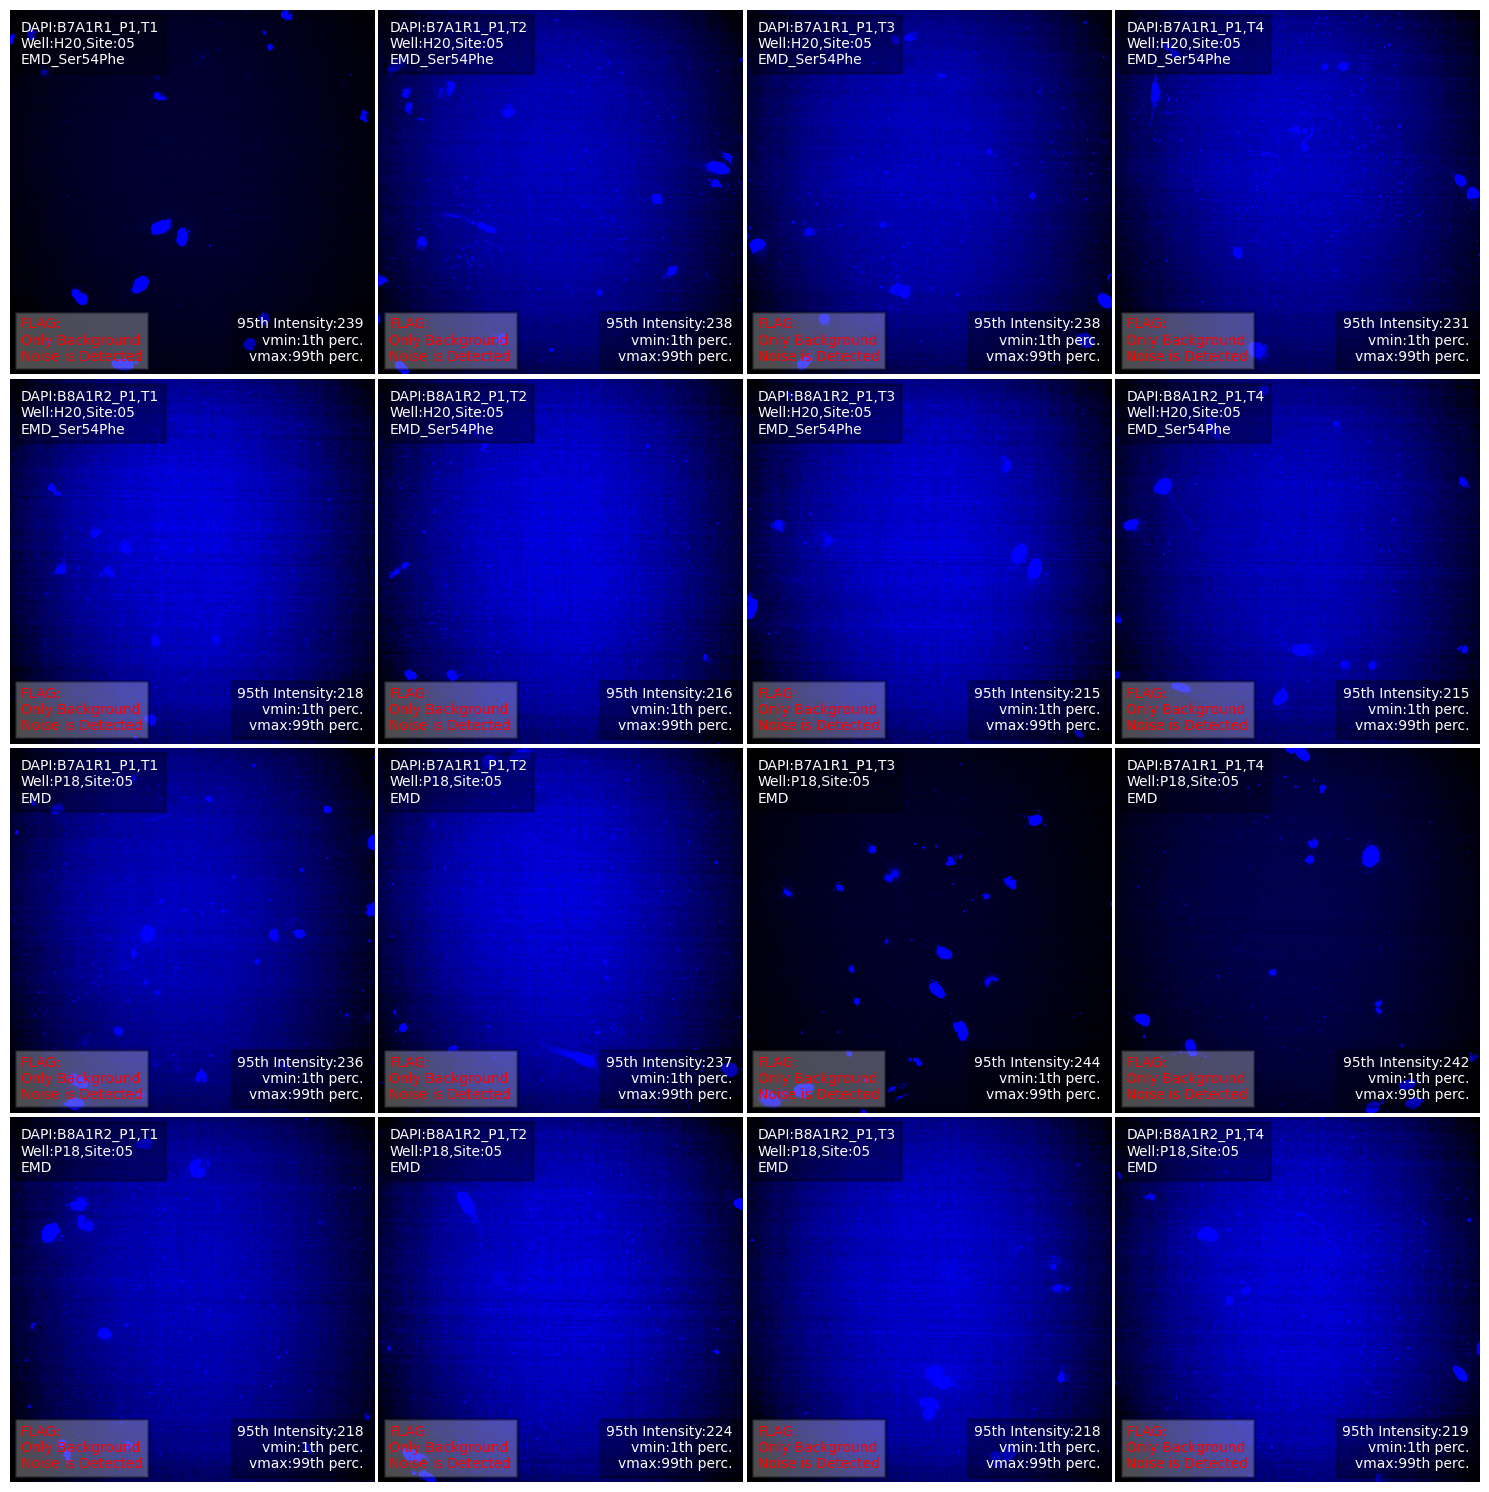

In [10]:
plot_allele(allele_meta_df.filter(
                pl.col("Metadata_Batch")=="2024_01_23_Batch_7"
            ), 
            "EMD",
            "EMD_Ser54Phe", 
            "DAPI",
            # ref_well=["I18"], 
            var_well=["H20"], 
            plate_img_qc=img_well_qc_sum_df, 
            site="05", 
            show_plot=True, 
            imgs_dir=TIFF_IMGS_DIR
)

<Figure size 640x480 with 0 Axes>

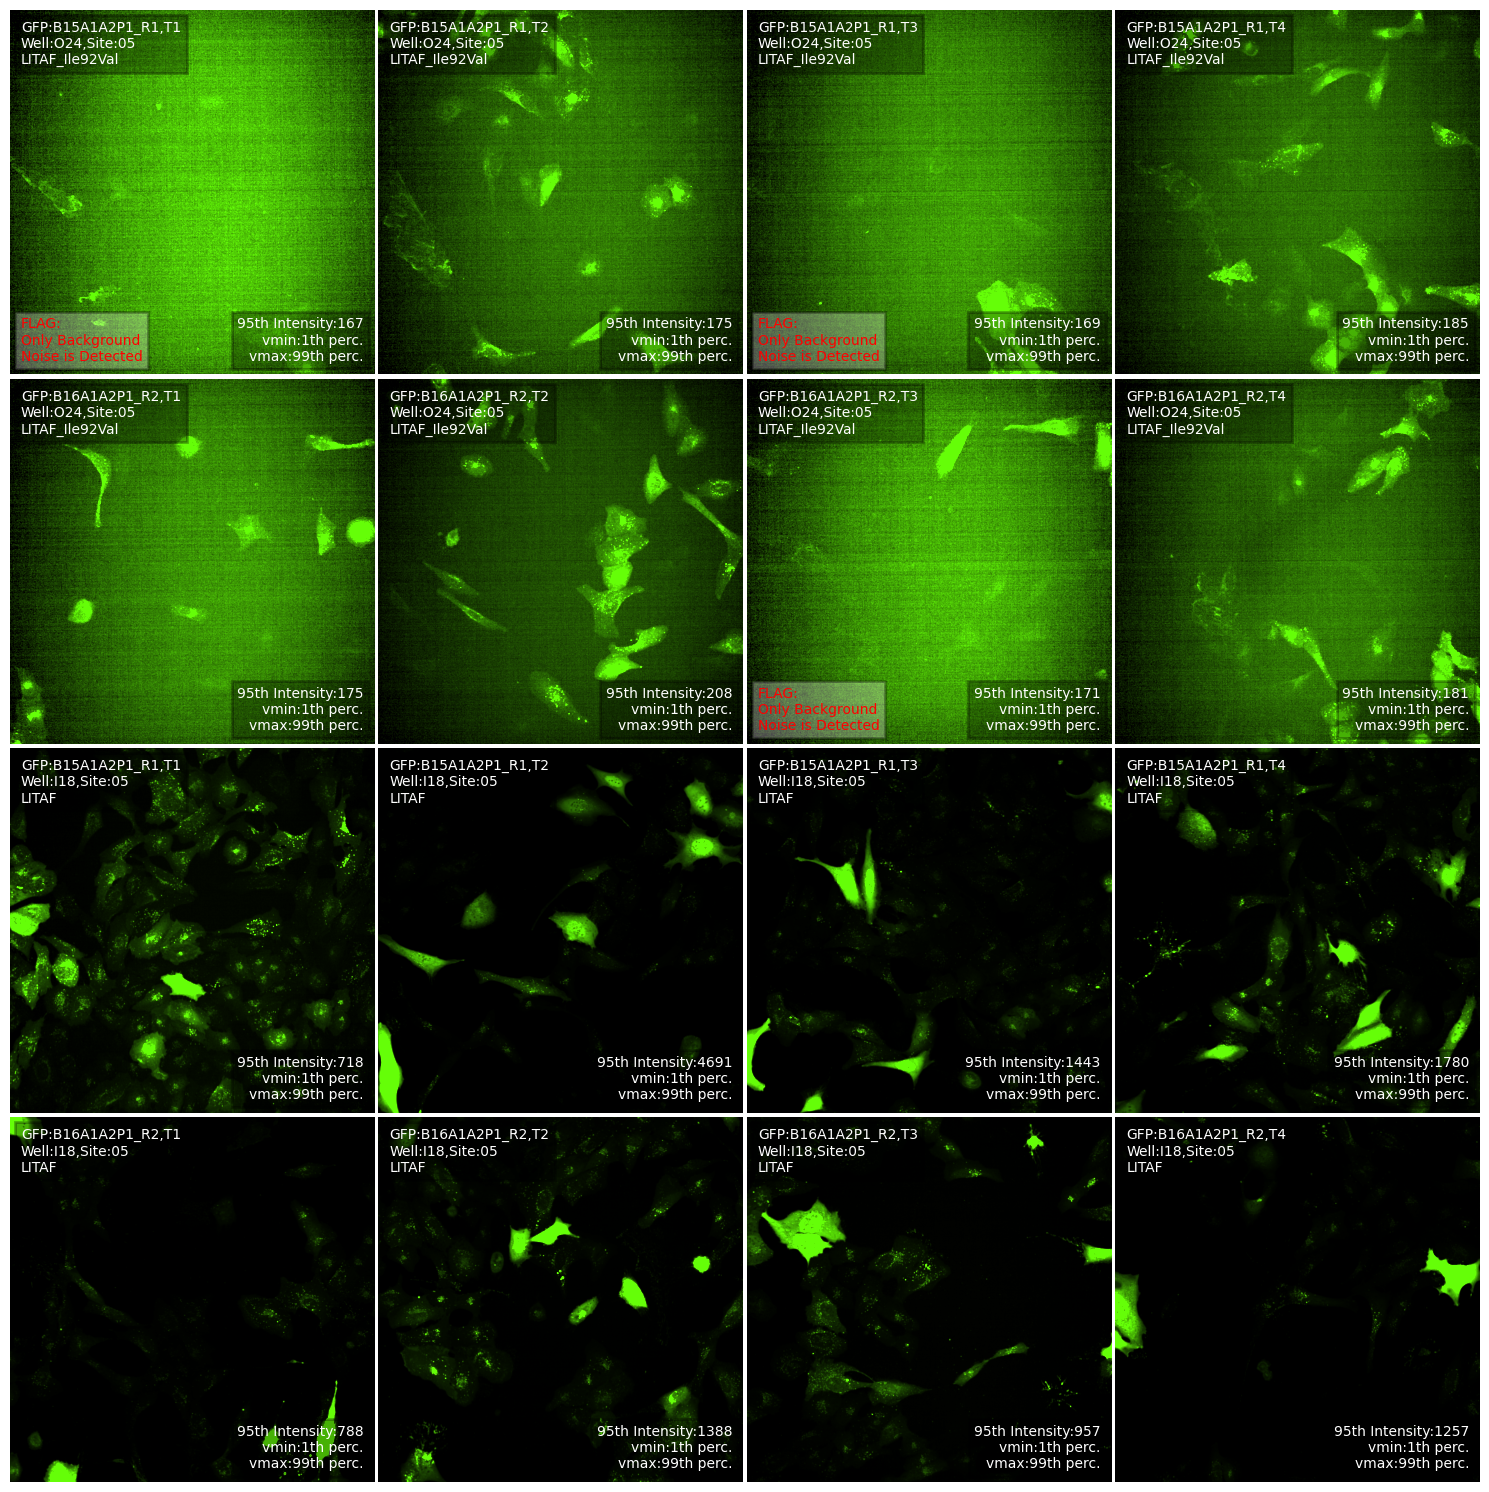

In [11]:
# allele_meta_df.filter(
#     pl.col("gene_allele")=="LITAF_Ile92Val",
#     pl.col("Metadata_Bio_Rep")=="2025_03_Batch_15-16"
# )

plot_allele(allele_meta_df.filter(
                pl.col("Metadata_Batch")=="2025_03_17_Batch_15"
            ), 
            "LITAF",
            "LITAF_Ile92Val", 
            "GFP",
            ref_well=["I18"], 
            var_well=["O24"], 
            plate_img_qc=img_well_qc_sum_df, 
            site="05", 
            show_plot=True, 
            imgs_dir=TIFF_IMGS_DIR
)